In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from properscoring import crps_gaussian
import datetime

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data, train_test_normalise
from useful_fun import plot_sliding_window, number_outof_CI, split_dataframe_by_position


In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data) # y is unnormalised: good!

# get date for x-axis in plots: mm-yyyy
def get_xticks(df):
    dff = df.groupby(by='m-y').first()
    pos = dff.ids; pos = pos[1:]
    labels = dff.index; labels = labels[1:]
    return pos, labels

2022-08-21 18:33:23.240410: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-21 18:33:23.814048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b2:00.0, compute capability: 7.5


# Sliding Window
### Simple one-latent function model with VGP

        y = f(x) + e
        f = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

In [3]:
def optimise_model(model, epochs=50):

    set_trainable(model.q_mu, False)
    set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(model.training_loss, variational_vars)
        adam_opt.minimize(model.training_loss, adam_vars)

    for epoch in range(1, epochs + 1):
        optimisation_step()

In [12]:
def slidingwindow_alg(splits, window_size, epochs=50, l0=77):    
    split_dataframes = split_dataframe_by_position(data, splits)

    # evaluation lists
    ELBO_train = []
    mse_train = []; mae_train = []; n_outof_CI_train = []
    mse_test = [];  mae_test = [];  n_outof_CI_test = []
    crps_train = []; crps_test = []

    # window sizes
    iterations = splits-window_size

    # which iteration to plot
    iteration_plot = [int(floor(iterations/2)), iterations-1]
    print('iterations to go through, plot: ', iterations, iteration_plot)

    ls = []; vs = []

    for i in range(splits-window_size):
        # create new dataframe
        df = pd.DataFrame()

        # select data
        for df_ind in range(window_size):
            if df_ind == 0:
                df = split_dataframes[i]
            else :
                df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

        whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
        pos, labels = get_xticks(whole_data)

        # normalise & separate data
        df_train = df; df_test = split_dataframes[i+window_size]
        df_train, df_test = train_test_normalise(df_train, df_test)
        x_train, y_train = separate_data(df_train)
        x_test, y_test = separate_data(df_test)
        
        # build model
        if i == 0:
            kernel = gpflow.kernels.RBF(lengthscales = l0, variance = 1)
        else:
            # re-optimize from starting values = optimizes hyperparameters in previous window
            kernel = gpflow.kernels.RBF(lengthscales = l, variance = v)
        model = gpflow.models.VGP((x_train, y_train), kernel, gpflow.likelihoods.Gaussian(), num_latent_gps=1)
        if i != 0: 
            model.q_mu.assign(q_mu)
            model.q_sqrt.assign(q_sqrt)
        model.likelihood.variance.prior = tfp.distributions.Normal(to_default_float(0), to_default_float(1))
        model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
        model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))

        # optimise/train step
        optimise_model(model, epochs=epochs)

        # save hyperparameters
        l = model.kernel.lengthscales.numpy()
        v = model.kernel.variance.numpy()
        ls.append(l); vs.append(v)
        q_mu = model.q_mu.numpy(); q_sqrt = model.q_sqrt.numpy();

        # predict
        mean_train, var_train = model.predict_y(x_train)
        mean_test, var_test = model.predict_y(x_test)

        # evaluate
        ELBO_train.append(model.elbo().numpy())
        mse_train.append(mean_squared_error(y_train, mean_train)); mae_train.append(mean_absolute_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
        mse_test.append(mean_squared_error(y_test, mean_test)); mae_test.append(mean_absolute_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))
        crps_train.append(np.mean(crps_gaussian(y_train, mean_train, np.sqrt(var_train)))); crps_test.append(np.mean(crps_gaussian(y_test, mean_test, np.sqrt(var_test))))

        if i in iteration_plot:
            plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=i)
        

    # Average evaluation metrics
    print('ELBO Avg: ', np.mean(ELBO_train))
    print('Train Avg. MSE, MAE, points outside CI: ', np.mean(mse_train), np.mean(mae_train), np.mean(n_outof_CI_train))
    print('Test Avg. MSE, MAE, points outside CI: ', np.mean(mse_test), np.mean(mae_test), np.mean(n_outof_CI_test))
    print('Avg. CRPS (train, test): ', np.mean(crps_train), np.mean(crps_test))


    # histogram of CI
    fig, ax = plt.subplots(1,2)
    ax[0].hist(n_outof_CI_train, bins=50)
    ax[0].set_title('Train')
    ax[1].hist(n_outof_CI_test, bins=50)
    ax[1].set_title('Test')
    plt.title('Histogram of number of points that lie outside 95% CI')
    plt.show()

    # evolution of metrics
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].plot(np.linspace(1,iterations, iterations), mse_train, '-', color='C0')
    ax[0].plot(np.linspace(1,iterations, iterations), mse_test, '-', color='orange')
    ax[0].set_ylabel('MSE')
    ax[0].set_xlabel('Windows')
    ax[1].plot(np.linspace(1,iterations, iterations), crps_train, '-', color='C0', label='Train set')
    ax[1].plot(np.linspace(1,iterations, iterations), crps_test, '-', color='orange', label='Test set')
    ax[1].set_ylabel('CRPS')
    ax[1].set_xlabel('Windows')
    plt.legend()
    plt.show()

    # evolution of ls and vs
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].plot(np.linspace(1,iterations, iterations), ls, '-')
    ax[0].set_ylabel('lengthscales')
    ax[0].set_xlabel('Windows')
    ax[1].plot(np.linspace(1,iterations, iterations), vs, '-')
    ax[1].set_ylabel('variances')
    ax[1].set_xlabel('Windows')
    plt.show()

    return print_summary(model, fmt='notebook')

iterations to go through, plot:  116 [58, 115]


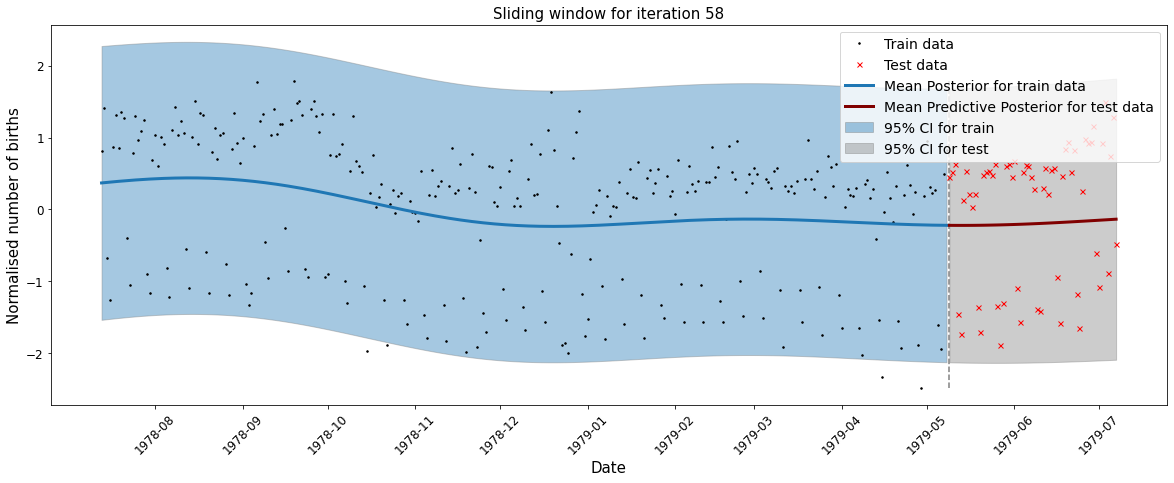

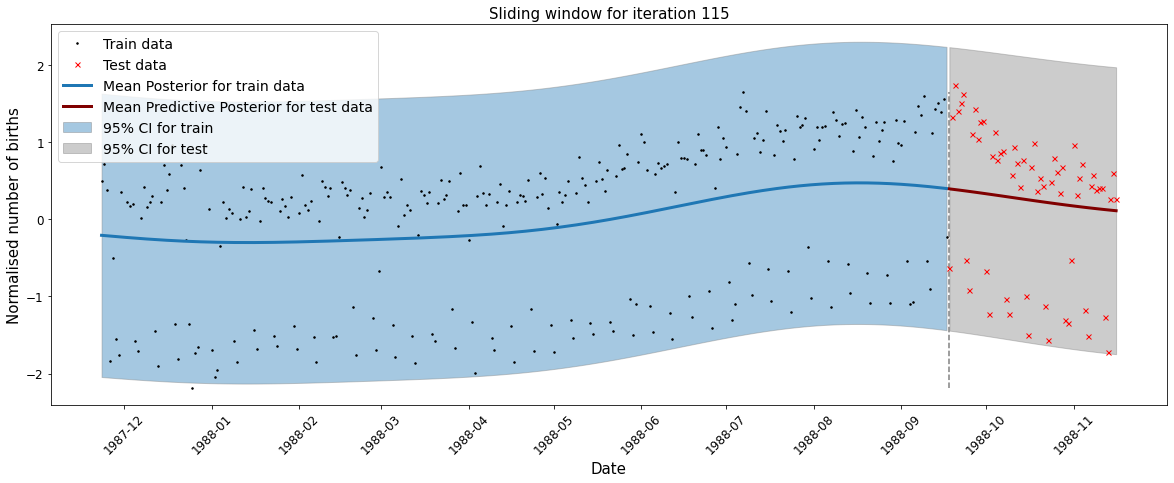

ELBO Avg:  -407.9910884171621
Train Avg. MSE, MAE, points outside CI:  0.844242604010429 0.7908985802424907 4.732758620689655
Test Avg. MSE, MAE, points outside CI:  1.0187488996922012 0.8469040250440749 1.9655172413793103
Avg. CRPS (train, test):  0.5301487243210073 0.5818732437611256


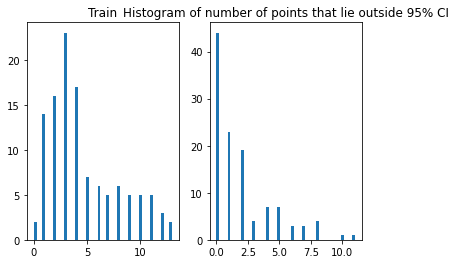

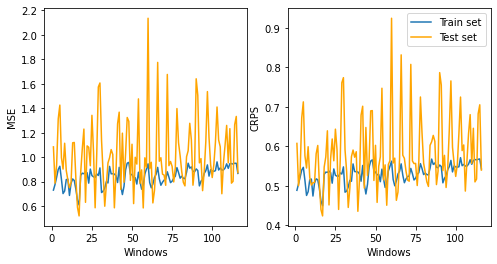

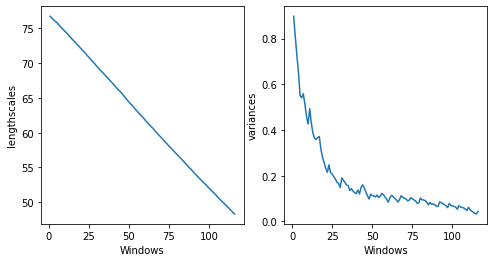

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.043784583324537066
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,48.31095749897751
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.8607073310682357
VGP.num_data,Parameter,Identity,,False,(),int32,300
VGP.q_mu,Parameter,Identity,,False,"(300, 1)",float64,[[-9.87772205e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 300, 300)",float64,"[[[6.59054775e-01, 0.00000000e+00, 0.00000000e+00..."


In [13]:
slidingwindow_alg(121, 5, epochs=30, l0=77)

iterations to go through, plot:  116 [58, 115]


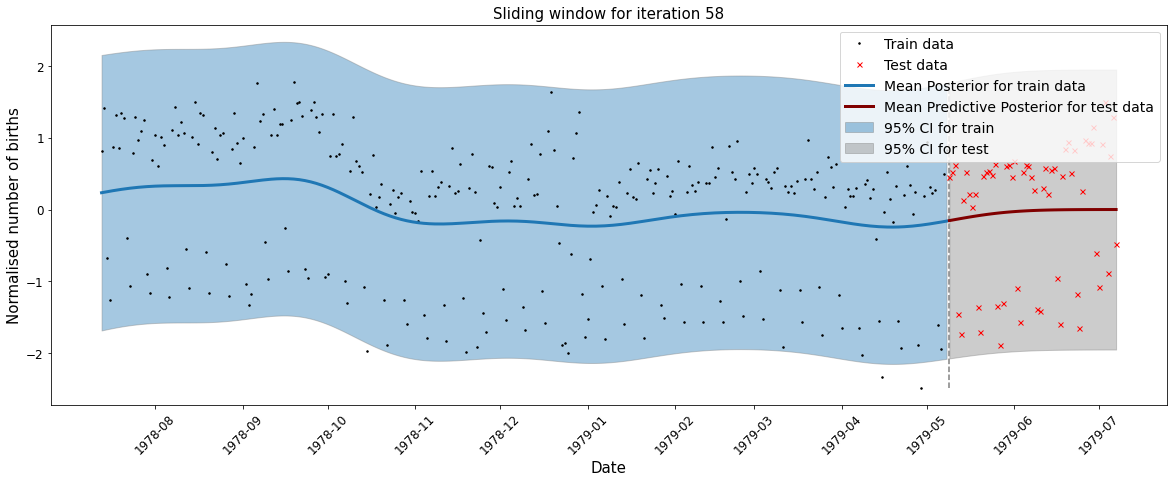

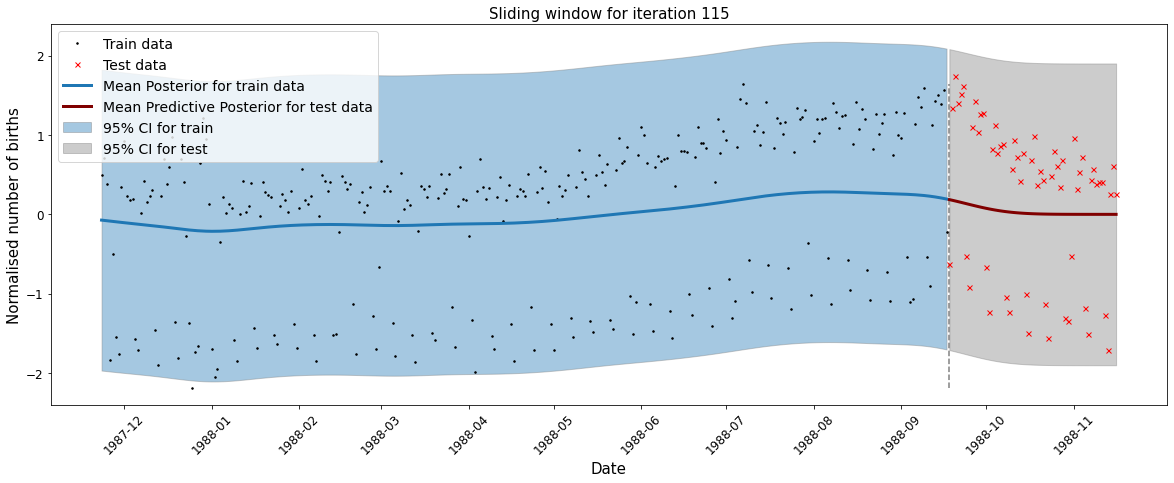

ELBO Avg:  -409.8949126675142
Train Avg. MSE, MAE, points outside CI:  0.8361764945367899 0.7886391480563715 3.5344827586206895
Test Avg. MSE, MAE, points outside CI:  1.0891268322031833 0.8641814657919192 2.4051724137931036
Avg. CRPS (train, test):  0.5276381318683563 0.6007234257552255


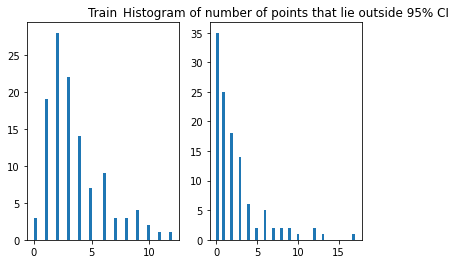

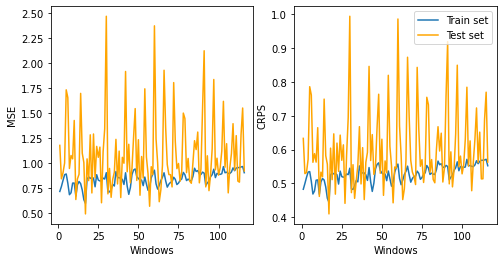

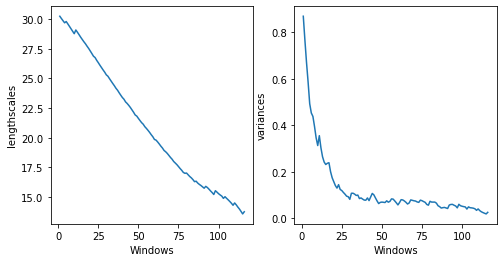

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.02511091745563927
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,13.77357560178553
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9154100680742643
VGP.num_data,Parameter,Identity,,False,(),int32,300
VGP.q_mu,Parameter,Identity,,False,"(300, 1)",float64,[[-0.45796382...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 300, 300)",float64,"[[[8.84864551e-01, 0.00000000e+00, 0.00000000e+00..."


In [14]:
slidingwindow_alg(121, 5, epochs=30, l0=30)

iterations to go through, plot:  116 [58, 115]


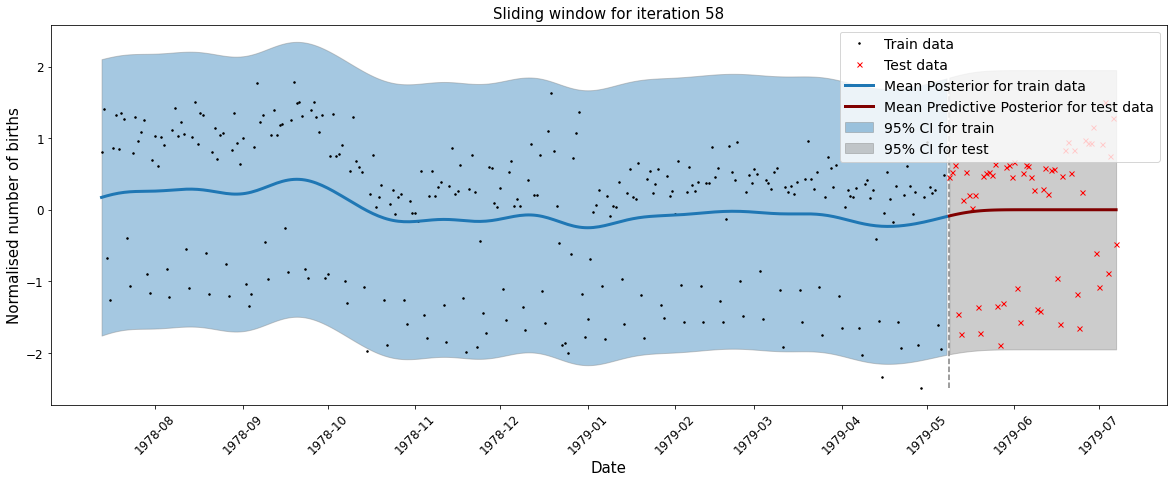

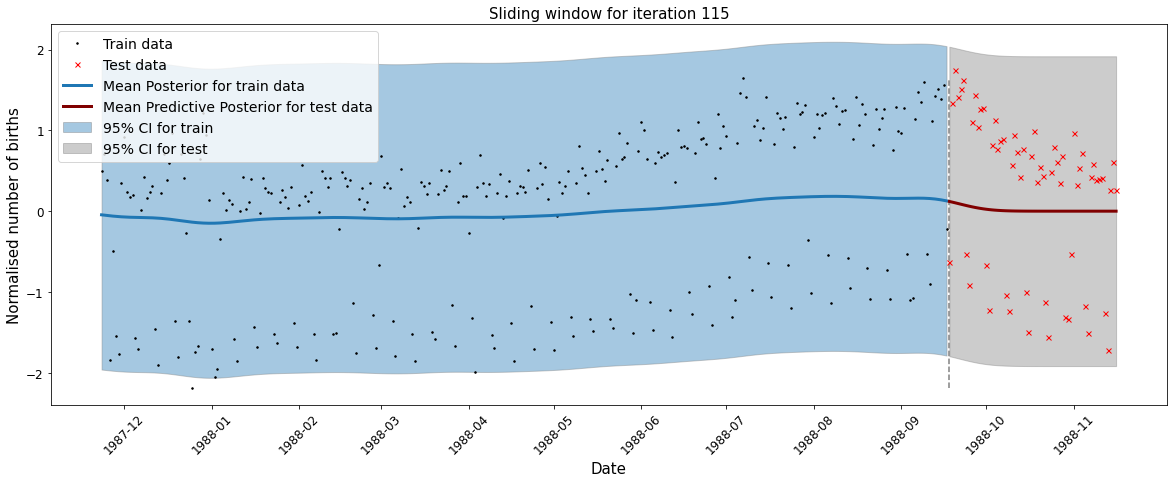

ELBO Avg:  -414.5409783679144
Train Avg. MSE, MAE, points outside CI:  0.8421627249613246 0.7879209703874939 3.2413793103448274
Test Avg. MSE, MAE, points outside CI:  1.133466230124778 0.875068224060389 2.7758620689655173
Avg. CRPS (train, test):  0.5293292019809651 0.6124099989144173


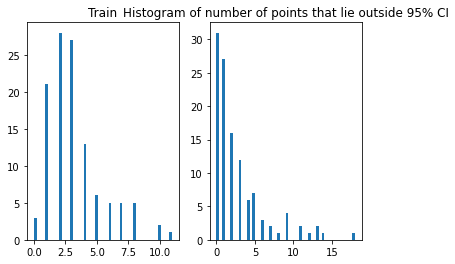

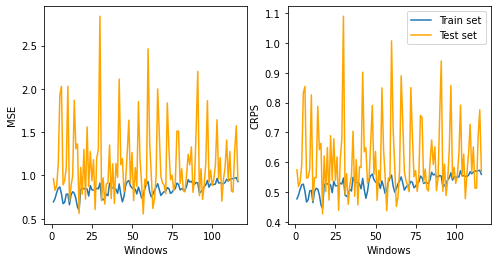

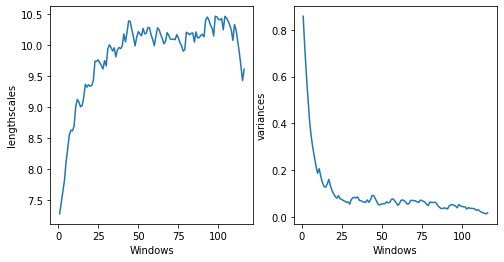

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.01799507437653861
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,9.612433560537804
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9379042462416632
VGP.num_data,Parameter,Identity,,False,(),int32,300
VGP.q_mu,Parameter,Identity,,False,"(300, 1)",float64,[[-0.33657566...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 300, 300)",float64,"[[[9.34917472e-01, 0.00000000e+00, 0.00000000e+00..."


In [15]:
slidingwindow_alg(121, 5, epochs=30, l0=7)

iterations to go through, plot:  54 [27, 53]


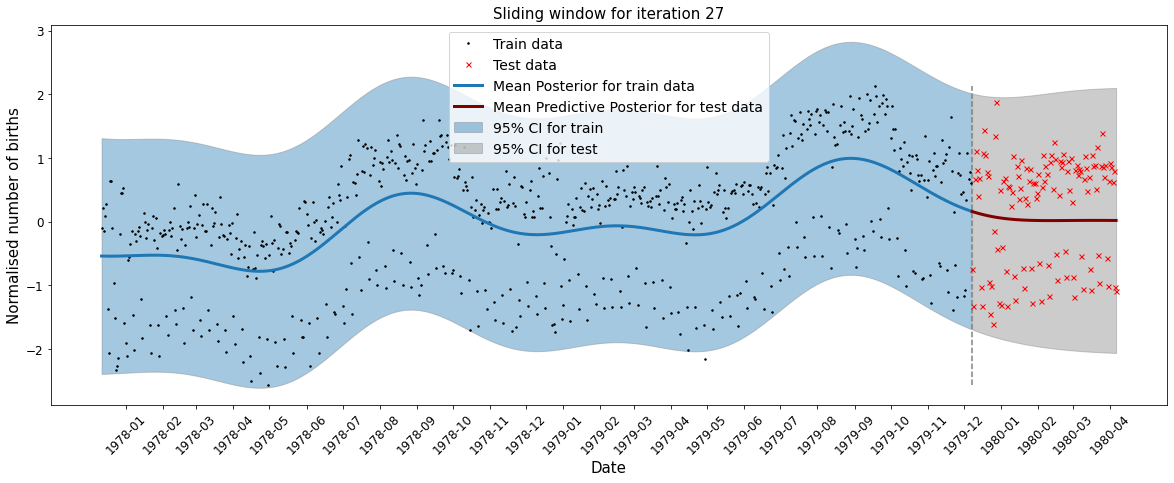

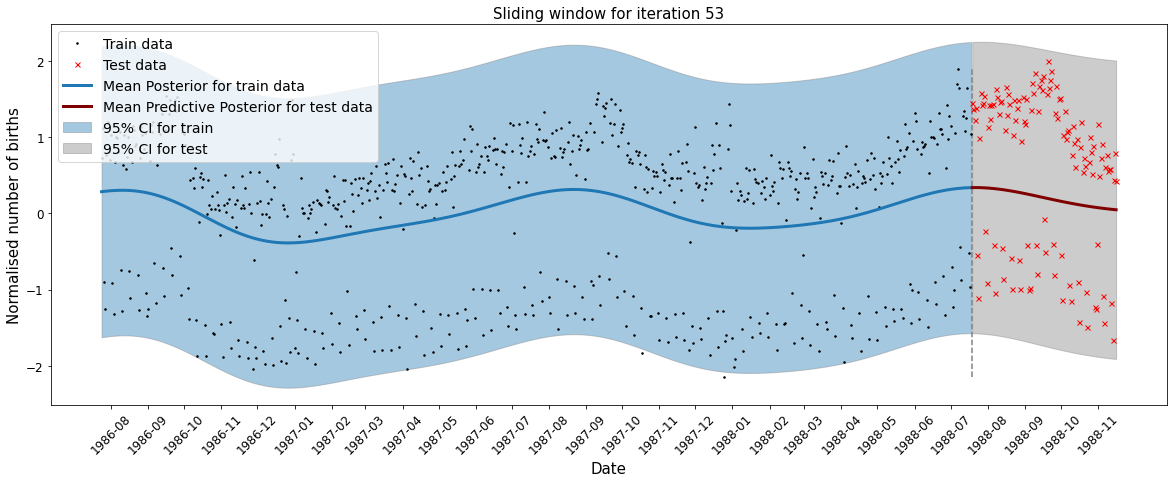

ELBO Avg:  -970.4904528628664
Train Avg. MSE, MAE, points outside CI:  0.8015042343282219 0.7705635579799581 6.037037037037037
Test Avg. MSE, MAE, points outside CI:  1.025970583764613 0.8648822967200149 2.074074074074074
Avg. CRPS (train, test):  0.5161722509216281 0.5842947608823287


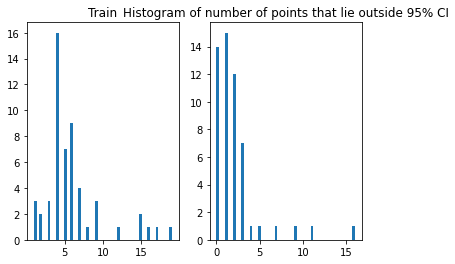

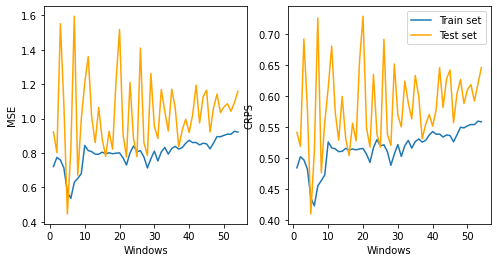

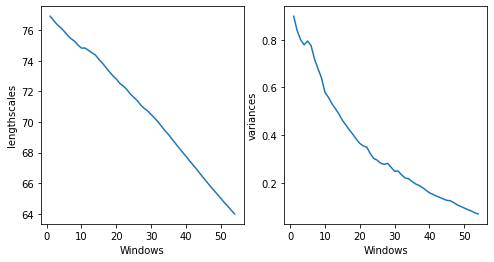

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.06917090127096609
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,63.987719048416345
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9273603994085254
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[1.08091553e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[5.50010740e-01, 0.00000000e+00, 0.00000000e+00..."


In [16]:
slidingwindow_alg(60, 6, epochs=30, l0=77)

iterations to go through, plot:  54 [27, 53]


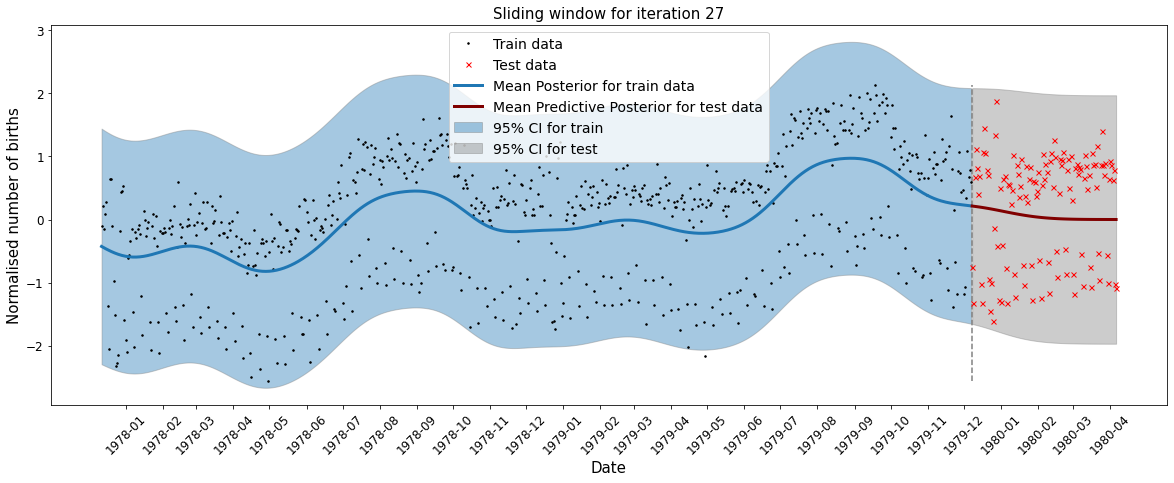

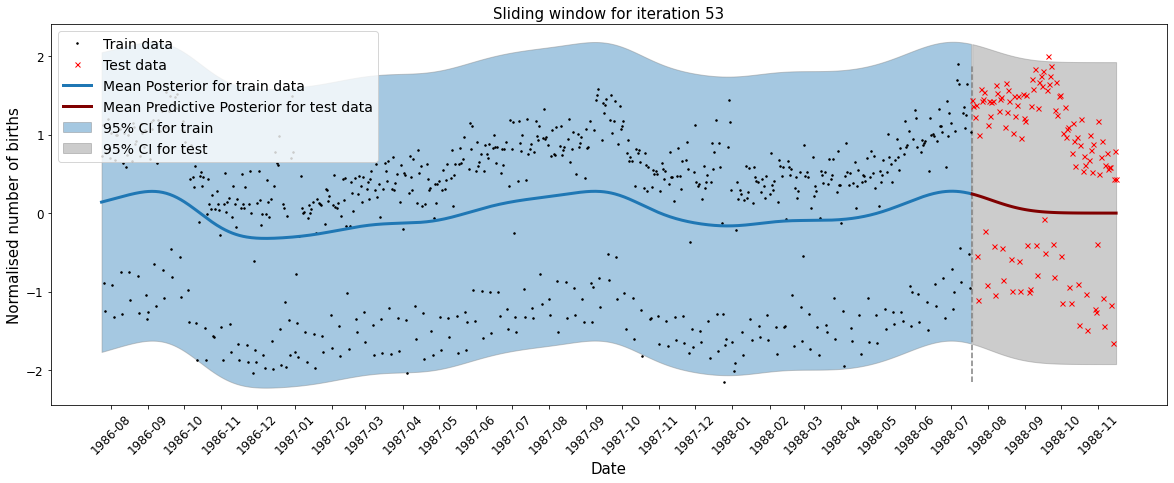

ELBO Avg:  -973.7708234771809
Train Avg. MSE, MAE, points outside CI:  0.7933795425254767 0.7688961148695407 4.611111111111111
Test Avg. MSE, MAE, points outside CI:  1.0800820132721003 0.8856329614559504 2.259259259259259
Avg. CRPS (train, test):  0.5138145615272455 0.6018720017439306


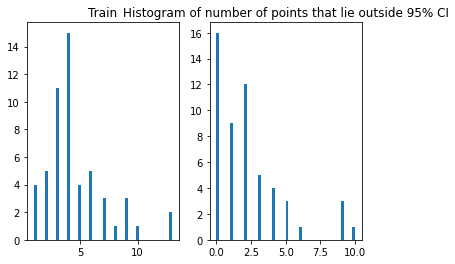

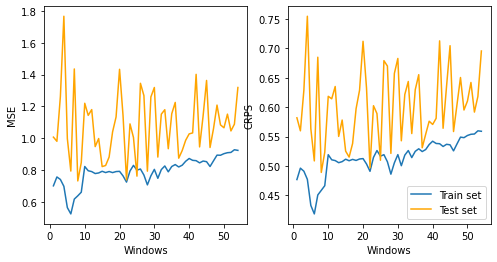

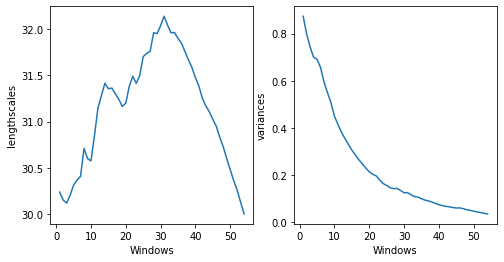

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.034390329527003646
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,30.003064083854863
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9278707340270012
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[7.55901191e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[7.60475794e-01, 0.00000000e+00, 0.00000000e+00..."


In [17]:
slidingwindow_alg(60, 6, epochs=30, l0=30)

iterations to go through, plot:  54 [27, 53]


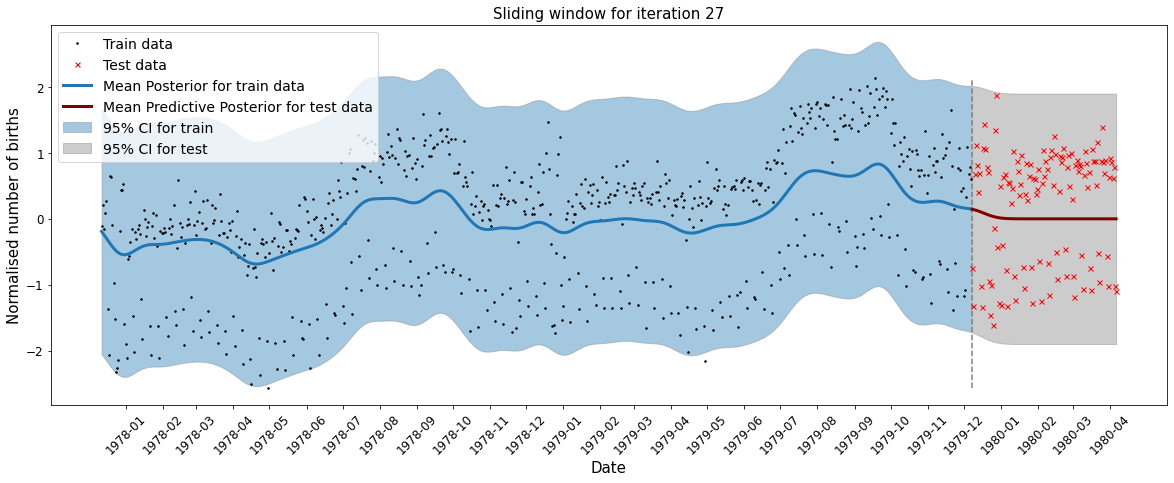

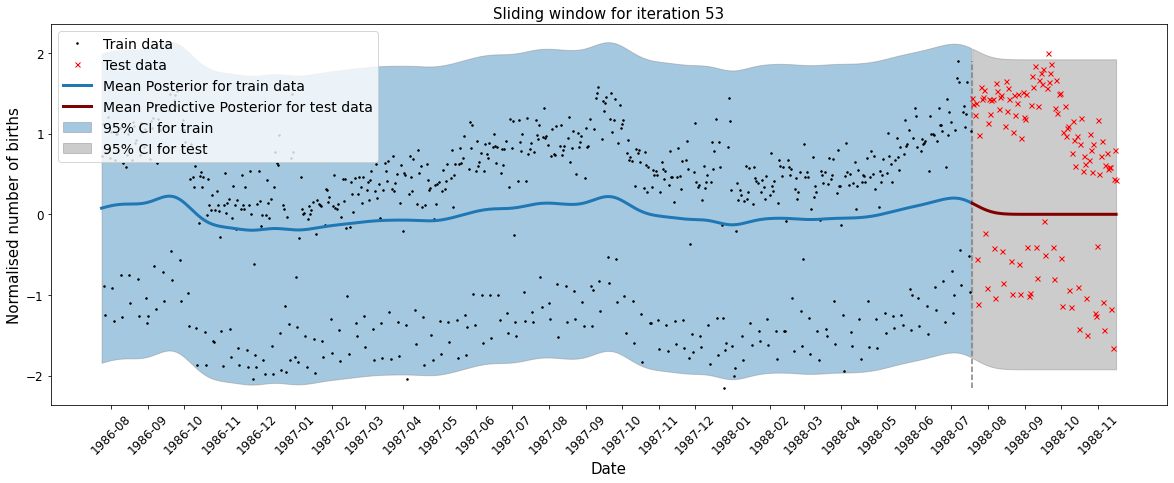

ELBO Avg:  -990.8687782194946
Train Avg. MSE, MAE, points outside CI:  0.7992356007484709 0.7679903112733981 4.37037037037037
Test Avg. MSE, MAE, points outside CI:  1.147085858581011 0.9067240045515355 4.111111111111111
Avg. CRPS (train, test):  0.5158218068371734 0.6200329815563328


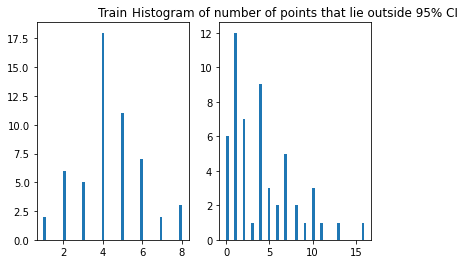

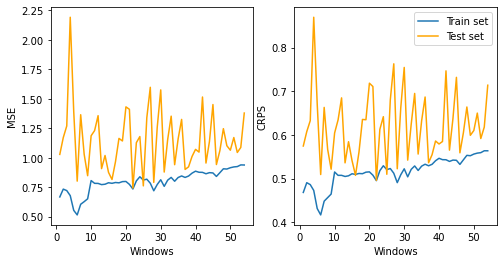

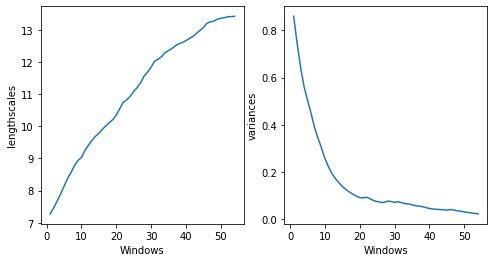

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.022619063661102556
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,13.426592509365559
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.9388609052487009
VGP.num_data,Parameter,Identity,,False,(),int32,726
VGP.q_mu,Parameter,Identity,,False,"(726, 1)",float64,[[5.06612593e-01...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 726, 726)",float64,"[[[8.91939802e-01, 0.00000000e+00, 0.00000000e+00..."


In [18]:
slidingwindow_alg(60, 6, epochs=30, l0=7)

iterations to go through, plot:  232 [116, 231]


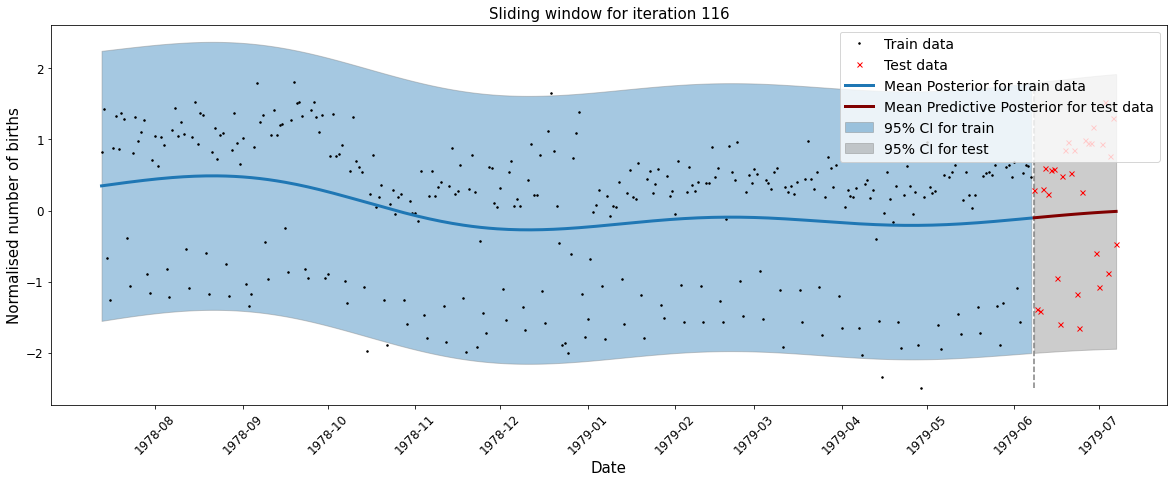

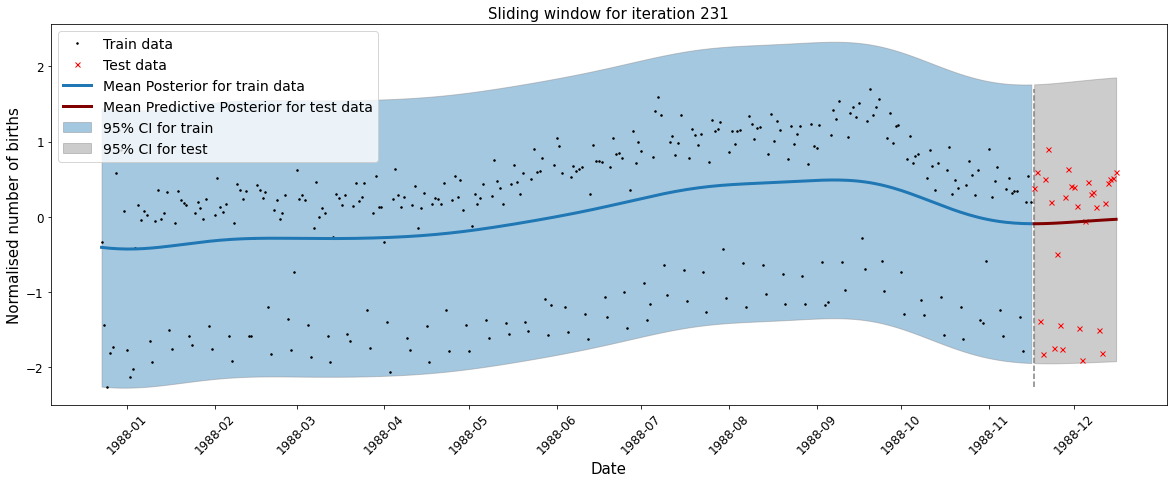

ELBO Avg:  -447.38395942790316
Train Avg. MSE, MAE, points outside CI:  0.8331807527871815 0.7869256207476387 5.146551724137931
Test Avg. MSE, MAE, points outside CI:  0.9491758216065335 0.8288346674022203 0.75
Avg. CRPS (train, test):  0.5268068390385438 0.5626998329272803


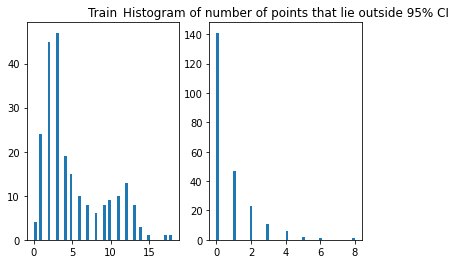

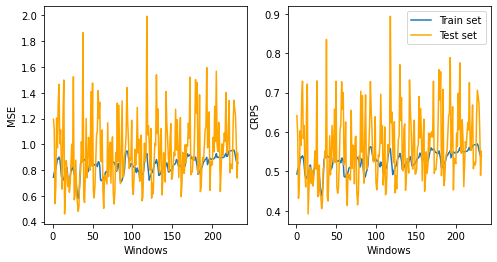

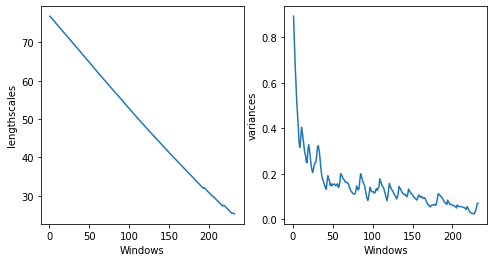

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.07151840581204995
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,25.2909937765042
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.8597442163727989
VGP.num_data,Parameter,Identity,,False,(),int32,330
VGP.q_mu,Parameter,Identity,,False,"(330, 1)",float64,[[-1.51511229e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 330, 330)",float64,"[[[6.73881947e-01, 0.00000000e+00, 0.00000000e+00..."


In [19]:
slidingwindow_alg(243, 11, epochs=30, l0=77)

iterations to go through, plot:  232 [116, 231]


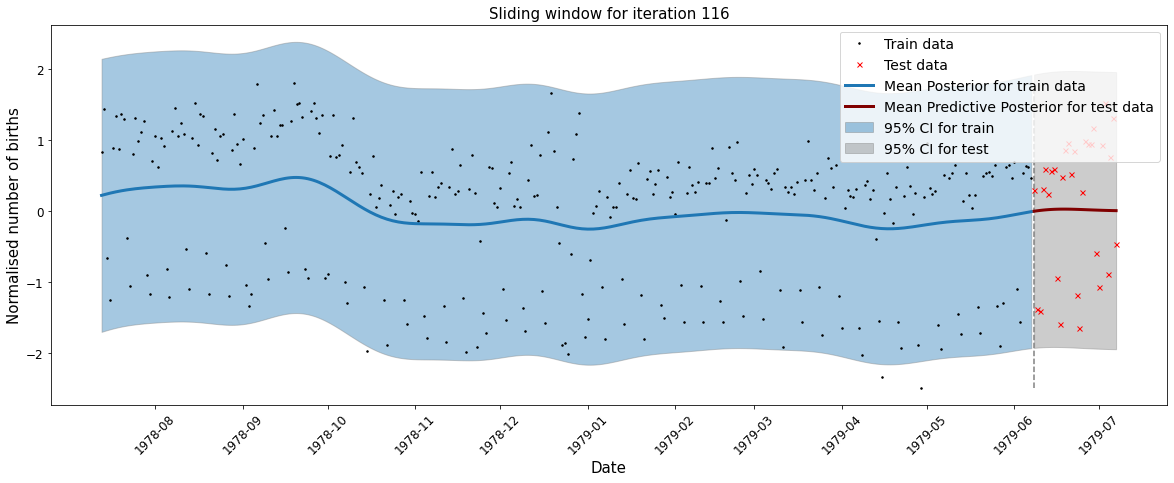

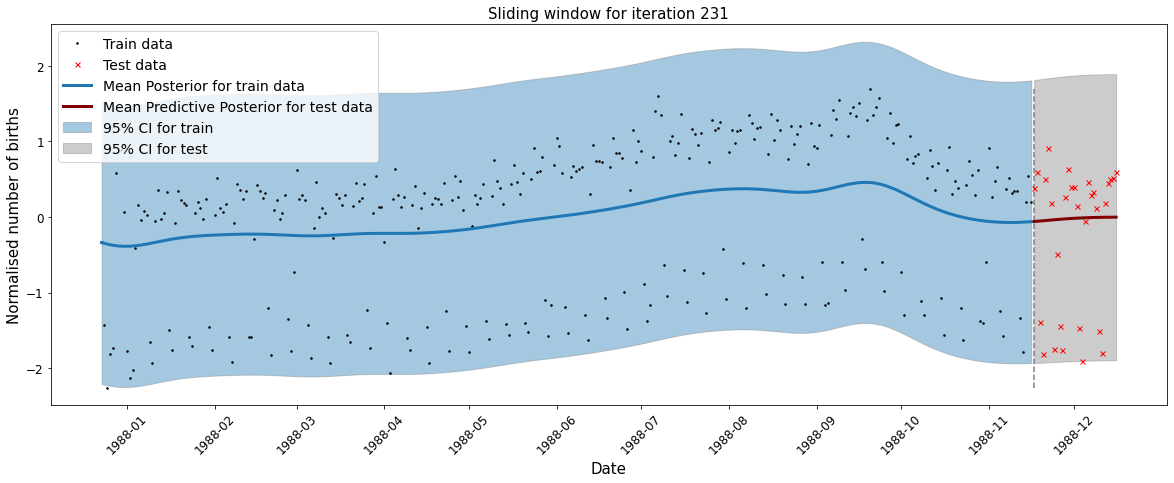

ELBO Avg:  -450.82718454063973
Train Avg. MSE, MAE, points outside CI:  0.8266222959346929 0.7850302819535385 3.8836206896551726
Test Avg. MSE, MAE, points outside CI:  1.0180328941997276 0.8425401662912699 1.0387931034482758
Avg. CRPS (train, test):  0.5246879578248179 0.581090436444785


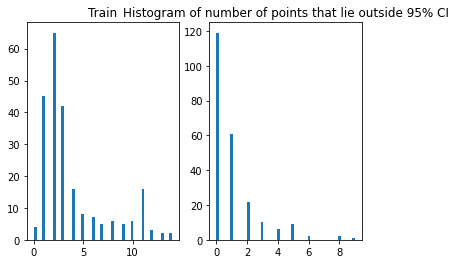

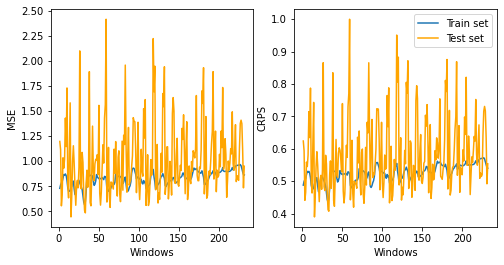

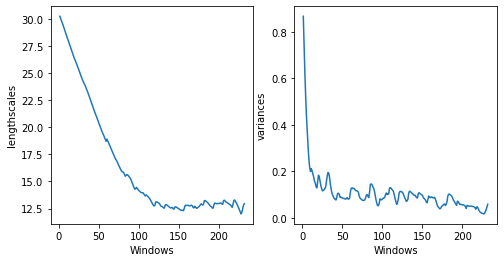

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.05794244973979729
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,12.954450713854236
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.8734843106302799
VGP.num_data,Parameter,Identity,,False,(),int32,330
VGP.q_mu,Parameter,Identity,,False,"(330, 1)",float64,[[-1.39984944e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 330, 330)",float64,"[[[7.98327116e-01, 0.00000000e+00, 0.00000000e+00..."


In [20]:
slidingwindow_alg(243, 11, epochs=30, l0=30)

iterations to go through, plot:  232 [116, 231]


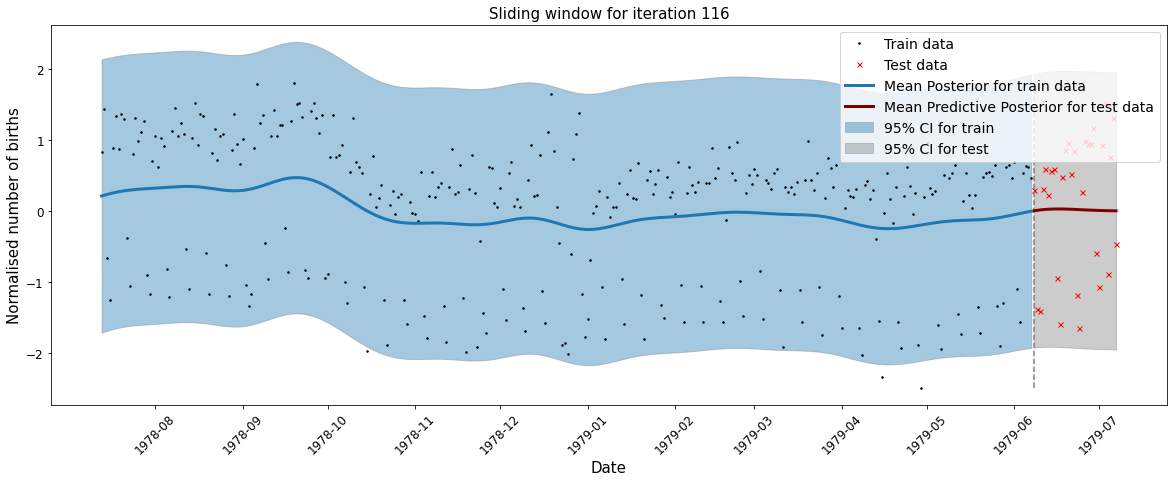

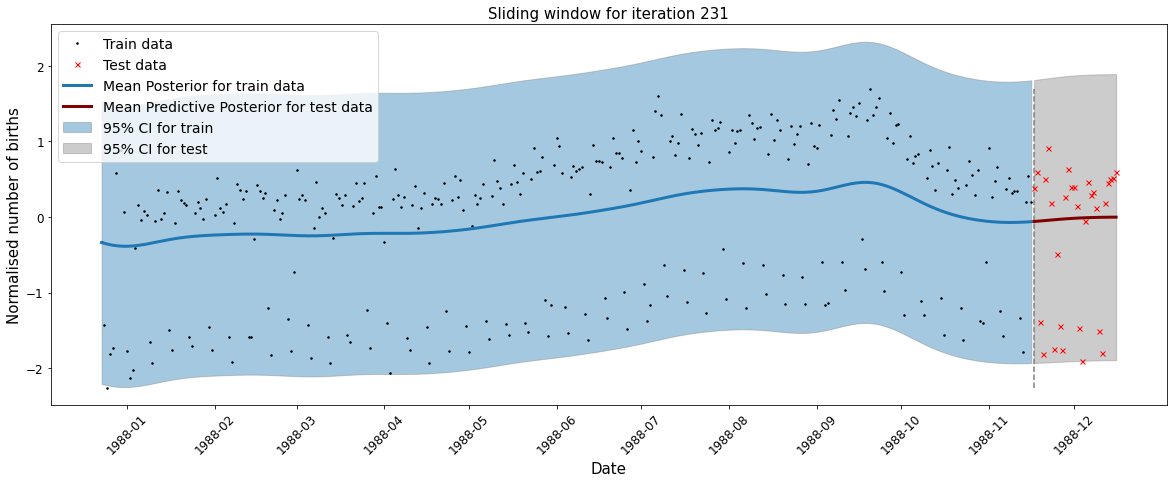

ELBO Avg:  -452.8060840878916
Train Avg. MSE, MAE, points outside CI:  0.8250378000919779 0.7839068807683398 3.538793103448276
Test Avg. MSE, MAE, points outside CI:  1.0521096370635865 0.8539891840357032 1.1724137931034482
Avg. CRPS (train, test):  0.5241535170312676 0.5905557150289653


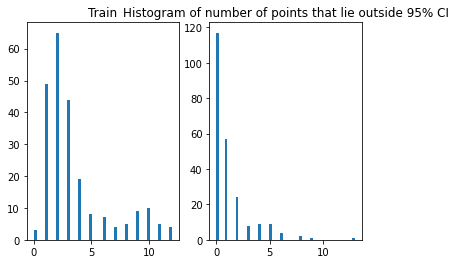

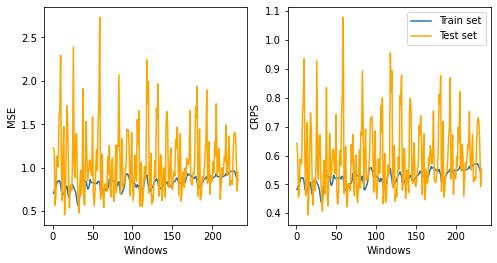

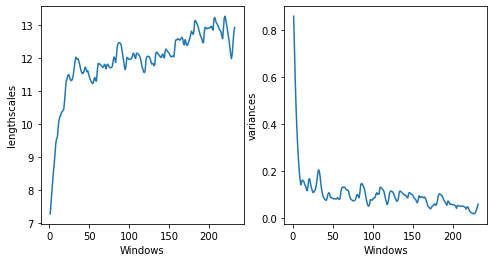

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.05786210844736088
VGP.kernel.lengthscales,Parameter,Softplus,InverseGamma,True,(),float64,12.928071383380207
VGP.likelihood.variance,Parameter,Softplus + Shift,Normal,True,(),float64,0.8735757498042263
VGP.num_data,Parameter,Identity,,False,(),int32,330
VGP.q_mu,Parameter,Identity,,False,"(330, 1)",float64,[[-1.39909133e+00...
VGP.q_sqrt,Parameter,FillTriangular,,False,"(1, 330, 330)",float64,"[[[7.98759462e-01, 0.00000000e+00, 0.00000000e+00..."


In [21]:
slidingwindow_alg(243, 11, epochs=30, l0=7)

In [22]:
# splits=121; window_size=5; epochs=10  
# split_dataframes = split_dataframe_by_position(data, splits)

# # evaluation lists
# ELBO_train = []
# mse_train = []; mae_train = []; n_outof_CI_train = []
# mse_test = [];  mae_test = [];  n_outof_CI_test = []

# # window sizes
# iterations = splits-window_size

# # which iteration to plot
# iteration_plot = np.random.randint(low=0, high=iterations)
# print('iterations to go through, plot: ', iterations, iteration_plot)

# ls = []; vs = []

# for i in range(splits-window_size):
#     print(i)
#     # create new dataframe
#     df = pd.DataFrame()

#     # # select data
#     for df_ind in range(window_size):
#         if df_ind == 0:
#             df = split_dataframes[i]
#         else :
#             df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

#     whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
#     pos, labels = get_xticks(whole_data)

#     # normalise & separate data
#     df_train = df; df_test = split_dataframes[i+window_size]
#     df_train, df_test = train_test_normalise(df_train, df_test)
#     x_train, y_train = separate_data(df_train)
#     x_test, y_test = separate_data(df_test)
    
#     # build model
#     if i == 0:
#         kernel = gpflow.kernels.RBF(lengthscales = 7, variance = 1)
#         model = gpflow.models.VGP((tf.Variable(x_train), tf.Variable(y_train)), kernel, gpflow.likelihoods.Gaussian(), num_latent_gps=1)
#         set_trainable(model.likelihood.variance, False)
#         model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(1), to_default_float(1))
#         model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(1), to_default_float(1))
#     else:
#         # update & re-optimize
#         gpflow.models.vgp.update_vgp_data(model, (x_train, y_train))
#         print_summary(model, fmt='notebook')

#     # optimise/train step
#     optimise_model(model, epochs=epochs)

#     # save hyperparameters
#     l = model.kernel.lengthscales.numpy()
#     v = model.kernel.variance.numpy()
#     ls.append(l); vs.append(v)

#     # predict
#     mean_train, var_train = model.predict_y(x_train)
#     mean_test, var_test = model.predict_y(x_test)

#     # evaluate
#     ELBO_train.append(model.elbo().numpy())
#     mse_train.append(mean_squared_error(y_train, mean_train)); mae_train.append(mean_absolute_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
#     mse_test.append(mean_squared_error(y_test, mean_test)); mae_test.append(mean_absolute_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))

#     if i == iteration_plot:
#         plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=1)
    

# # Average evaluation metrics
# print('ELBO Avg: ', np.mean(ELBO_train))
# print('Train Avg. MSE, MAE, points outside CI: ', np.mean(mse_train), np.mean(mae_train), np.mean(n_outof_CI_train))
# print('Test Avg. MSE, MAE, points outside CI: ', np.mean(mse_test), np.mean(mae_test), np.mean(n_outof_CI_test))

# # histogram of CI
# fig, ax = plt.subplots(1,2)
# ax[0].hist(n_outof_CI_train, bins=50)
# ax[0].set_title('Train')
# ax[1].hist(n_outof_CI_test, bins=50)
# ax[1].set_title('Test')
# plt.title('Histogram of number of points that lie outside 95% CI')
# plt.show()

# # evolution of metrics
# fig, ax = plt.subplots(1,2, figsize=(8,4))
# ax[0].plot(np.linspace(1,iterations, iterations), mse_train, '-', color='C0')
# ax[0].plot(np.linspace(1,iterations, iterations), mse_test, '-', color='orange')
# ax[0].set_ylabel('MSE')
# ax[0].set_xlabel('Windows')
# ax[1].plot(np.linspace(1,iterations, iterations), mae_train, '-', color='C0', label='Train set')
# ax[1].plot(np.linspace(1,iterations, iterations), mae_test, '-', color='orange', label='Test set')
# ax[1].set_ylabel('MAE')
# ax[1].set_xlabel('Windows')
# plt.legend()
# plt.show()

# # evolution of ls and vs
# fig, ax = plt.subplots(1,2, figsize=(8,4))
# ax[0].plot(np.linspace(1,iterations, iterations), ls, '-')
# ax[0].set_ylabel('lengthscales')
# ax[0].set_xlabel('Windows')
# ax[1].plot(np.linspace(1,iterations, iterations), vs, '-')
# ax[1].set_ylabel('variances')
# ax[1].set_xlabel('Windows')
# plt.show()

# print_summary(model, fmt='notebook')